Version notes:

Next steps -- Notebook series 02x:
- analyze a rolling 60 to 90 days of travel out from end of search window
- x-axis = departure date, y-axis = lenght of stay, up to 30 days

Subversions:
- d: push out to 90 or 120 days of travel
- c: use `shop_vol` input data -- data aggregated specifically to look at shopping volume (and by extension its presence / absence)
    - previous versions had used data aggregated for lowest fare analysis

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

In [2]:
# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

"""
A note on dates, datetime objects, and dates as strings
- outDeptDt, inDeptDt: strings, from estreaming data
    - add conversion to datetime objects (outDeptDt, inDeptDt) so 
        it"s easier to do "math" on them
    - use string format for inDeptDt for final pivot table
        - when dates become columns names, they don"t display
            in human-readable format
- searchDt: string, added during data prep / agg (see other script)
    - must convert to datetime, then numeric (unix timestamp)
        - latter is required by Window function
"""

In [3]:
# =============================

# VARIABLES & ARGUMENTS
# ----------------

input_dir = "/user/kendra.frederick/shop_vol/markets/v2_encoded"


APP_NAME = "KF-ShopGrid-Jupyter"

# input data should span shopping dates from 08/08 - 08/25, inclusive
# there is a week of missing data, however (8/15 - 8/19)
# we could derive this from data, instead of supplying as an argument
shop_start_str = "2022-08-08" 
shop_end_str = "2022-08-25" 

In [4]:
# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.master","yarn"),
        ("spark.app.name", APP_NAME),
        ("spark.driver.memory","20g"),
        ("spark.executor.memory", "10g"),
        ("spark.executor.instances", 5),
        ("spark.executor.cores", "5"),
        ('spark.sql.crossJoin.enabled', True)
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

In [5]:
spark.sparkContext.applicationId

'application_1658797823938_1719'

# dates

no longer need a grid of travel dates since we are look at a range of stay durations

In [6]:
num_travel_days = 120 # 90
max_stay_duration = 30

# SEARCH DATES
search_start = datetime.datetime.strptime(shop_start_str, "%Y-%m-%d")
search_end = datetime.datetime.strptime(shop_end_str, "%Y-%m-%d")
num_search_days = (search_end - search_start).days + 1

travel_start = search_end + datetime.timedelta(days=1)
travel_end = travel_start + datetime.timedelta(days=num_travel_days)
travel_start_str = travel_start.strftime("%Y-%m-%d")
travel_end_str = travel_end.strftime("%Y-%m-%d")

last_return = travel_end + datetime.timedelta(days=max_stay_duration)

Technically, we should construct an outbound-departure date x trip duration grid, but in first iteration, didn't see need to do this (there was always at least 1 trip duration for each departure date, and vice versa)

In [7]:
travel_dates_list = [travel_start + datetime.timedelta(days=x) for x in range(num_travel_days)]
# travel_date_str_list = [x.strftime("%Y%m%d") for x in travel_dates_list]

travel_date_data = [(x, ) for x in travel_dates_list]
travel_date_df = spark.createDataFrame(
    data=travel_date_data, schema=["outDeptDt_dt"])

In [8]:
stay_duration_data = [(x, ) for x in range(max_stay_duration)]
stay_dur_df = spark.createDataFrame(
    data=stay_duration_data, schema=["stay_duration"])

In [9]:
travel_date_cross_df = (travel_date_df.crossJoin(stay_dur_df))

In [14]:
# this works in Python2
# travel_date_cross_df.show(5)

Py4JJavaError: An error occurred while calling o103.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 4 times, most recent failure: Lost task 0.3 in stage 0.0 (TID 3, shldvfsdh006.tvlport.net, executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/data/10/hadoop/yarn/local/usercache/ccoadmin/appcache/application_1658797823938_1718/container_e82_1658797823938_1718_01_000002/pyspark.zip/pyspark/worker.py", line 125, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 3.6 than that in driver 3.7, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.sql.execution.joins.UnsafeCartesianRDD.compute(CartesianProductExec.scala:56)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1925)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:333)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$org$apache$spark$sql$Dataset$$execute$1$1.apply(Dataset.scala:2378)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2780)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$execute$1(Dataset.scala:2377)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collect(Dataset.scala:2384)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2120)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2119)
	at org.apache.spark.sql.Dataset.withTypedCallback(Dataset.scala:2810)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2119)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2334)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:248)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/data/10/hadoop/yarn/local/usercache/ccoadmin/appcache/application_1658797823938_1718/container_e82_1658797823938_1718_01_000002/pyspark.zip/pyspark/worker.py", line 125, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 3.6 than that in driver 3.7, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.sql.execution.joins.UnsafeCartesianRDD.compute(CartesianProductExec.scala:56)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


Might be more correct to perform the 60-day rolling travel date analysis by each search date. Need to think about how to scale up shopping days, and start to look at sesonality effects

In [10]:
# load markets to analyze
markets_path = "/user/kendra.frederick/shop_grid/markets.csv"
markets_df = spark.read.csv(markets_path, header=True)
print("Analyzing {} markets".format(markets_df.count()))

# column name is wrong
markets_df = markets_df.withColumnRenamed("market_key_encoded", "market_key_decoded")

temp = markets_df.select("market_key_decoded").collect()
market_list = [x["market_key_decoded"] for x in temp]

Analyzing 48 markets


Define additional break-outs (these are included in `markets_list`, though)

In [11]:
us_domestic_markets = ["JFK-LAX",
"LAX-JFK",
"DFW-ORD",
"ORD-DFW",
"ATL-LAS",
"LAS-ATL",
"SFO-HNL",
"HNL-SFO",
"SFO-LAX",
"LAX-SFO",]


destination_markets = [# destination
"LHR-BKK",
"BKK-LHR",
"LHR-DIA",
"CDG-DIA",
"GIG-DIA",
"GRU-DIA",
"FRA-DIA",
"MEX-DIA",
"JFK-DIA",
"LAX-DIA",
"MIA-CUN",
"ATL-CUN",
]


In [12]:
df = spark.read.parquet(input_dir)
df = df.withColumn("market_key_decoded", 
    F.concat_ws("-", F.col("origin_decoded"), F.col("dest_decoded")))

df_join = df.join(F.broadcast(markets_df), on="market_key_decoded", how="inner")

# convert Dept dates (which are strings) to datetime
df_join.registerTempTable("data")
df_join = spark.sql("""
    SELECT *,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(outDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS outDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(inDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS inDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(searchDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS searchDt_dt
    FROM data
""")


# filter on dates & round-trip
df_filt = (df_join
            .filter(F.col("outDeptDt_dt").between(travel_start, travel_end))
            .filter(F.col("searchDt_dt") >= search_start)
            .filter(F.col("searchDt_dt") <= search_end)
            # Note: when we filter on stay duration below, this also
            # effectively accomplishes filtering on round-trip == 1
            .filter(F.col("round_trip") == 1)
        )



# group by market and count shops
cnt_df = (df_filt
            .groupBy(["market_key_decoded", 
                        "searchDt_dt", "outDeptDt_dt", "inDeptDt_dt", "round_trip"
                        # these aren't used any longer
                        # "outDeptDt", "inDeptDt", "searchDt"
                        ])
            .agg(
                F.sum("solution_counts").alias("sum_solution_counts"),
                F.sum("shop_counts").alias("sum_shop_counts")
            )
            .withColumn("shop_ind", F.lit(1)) # add an indicator column
            )

cnt_df = cnt_df.withColumn('stay_duration',
                F.datediff(
                    F.col('inDeptDt_dt'), F.col('outDeptDt_dt'))
                )
cnt_df.coalesce(1)
# cnt_df.write.mode("overwrite").parquet(processed_data_path)

DataFrame[market_key_decoded: string, searchDt_dt: date, outDeptDt_dt: date, inDeptDt_dt: date, round_trip: int, sum_solution_counts: bigint, sum_shop_counts: bigint, shop_ind: int, stay_duration: int]

In [ ]:
# file_name = ("cnt_df_search" + "_shop_" + shop_start_str + "_" + shop_end_str 
#              + "_travel_" + str(num_travel_days) + "-days")
# cnt_df.coalesce(1).write.mode("overwrite").parquet(
#     "/user/kendra.frederick/shop_grid/tmp/" + file_name)

In [25]:
cnt_df.show(5)

+------------------+-----------+------------+-----------+----------+-------------------+---------------+--------+-------------+
|market_key_decoded|searchDt_dt|outDeptDt_dt|inDeptDt_dt|round_trip|sum_solution_counts|sum_shop_counts|shop_ind|stay_duration|
+------------------+-----------+------------+-----------+----------+-------------------+---------------+--------+-------------+
|           LHR-IST| 2022-08-25|  2022-09-01| 2022-09-08|         1|              81806|           1004|       1|            7|
|           IST-LHR| 2022-08-25|  2022-09-07| 2022-09-14|         1|               3622|             78|       1|            7|
|           JFK-LAX| 2022-08-25|  2022-11-04| 2022-11-14|         1|              18560|             72|       1|           10|
|           JFK-LHR| 2022-08-25|  2022-09-16| 2022-10-08|         1|               2768|             13|       1|           22|
|           LHR-BKK| 2022-08-25|  2022-09-23| 2022-09-30|         1|               7026|            128|

In [24]:
cnt_df.count()

698096

Small enough to send to memory in Pandas?...

In [19]:
cnt_df = cnt_df.filter(F.col('stay_duration').between(0, max_stay_duration))

In [20]:
cnt_pdf = cnt_df.toPandas()

Oh yeah.

# loop over markets and save heatmaps

In [14]:
out_dir = "./output/v2/{}-days/".format(num_travel_days)
out_dir

'./output/v2/120-days/'

In [21]:
def pivot_plot_save(market, input_df, save_fig=True):
    print(f"Working on {market}")
    if isinstance(input_df, pd.DataFrame):
        market_df = input_df[input_df["market_key_decoded"] == market]
        market_agg_pdf = (market_df.groupby(["outDeptDt_dt", "stay_duration"])
                          .agg({"shop_ind": "sum",
                                "searchDt_dt": "max",
                                "sum_shop_counts": "sum"
                               })
                         )
        market_agg_pdf.columns = ["num_shop_days", "last_shop_date", "total_num_shops"]
        market_agg_pdf = market_agg_pdf.reset_index()
    else:
        market_df = input_df.filter(F.col("market_key_decoded") == market)

        market_agg_df = (market_df
            .groupby("outDeptDt_dt", "stay_duration")
            .agg(
                F.sum("shop_ind").alias("num_shop_days"),
                # note: we are taking max of a string; confirmed that this works in Python
                F.max("searchDt_dt").alias("last_shop_date"),
                F.sum("sum_shop_counts").alias("total_num_shops")
            )
        )

        market_agg_pdf = market_agg_df.toPandas()

    pvt = market_agg_pdf.pivot(index="stay_duration", columns="outDeptDt_dt", values="num_shop_days")

    with sns.axes_style("white"):
        plt.figure(figsize=(num_travel_days//3, num_search_days//3))
        sns.heatmap(pvt, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'label': 'num days with shop',
                              'shrink': 0.5,
                             });
        plt.title("Total number shop days for " + market);
        plt.ylabel("stay duration (days)")
        plt.xlabel("out-bound Departure date");
    
    if save_fig:
        file_name = (market + "_shop_" + shop_start_str + "_" + shop_end_str 
                     + "_travel_" + str(num_travel_days) + "-days")
        plt.savefig(out_dir + file_name + ".png", format="png")

Working on LHR-JFK


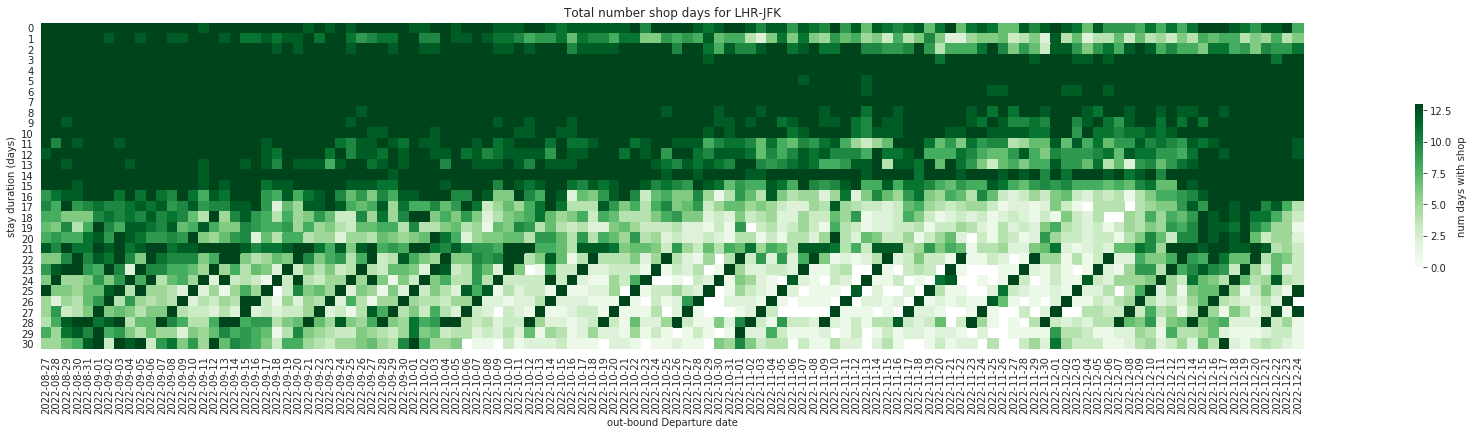

In [22]:
pivot_plot_save('LHR-JFK', cnt_pdf, False)

Here goes nothing

In [23]:
chunk = 12

Working on LHR-JFK
Working on JFK-LHR
Working on SIN-BKK
Working on BKK-SIN
Working on ICN-BKK
Working on BKK-ICN
Working on LHR-IST
Working on IST-LHR
Working on LHR-LAX
Working on LAX-LHR
Working on LED-AYT
Working on AYT-LED


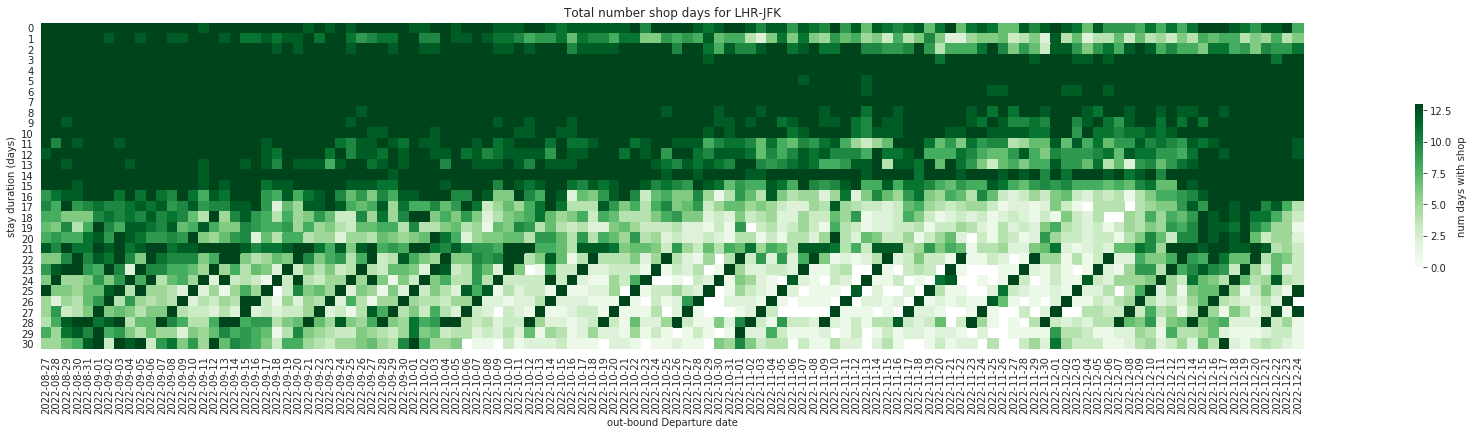

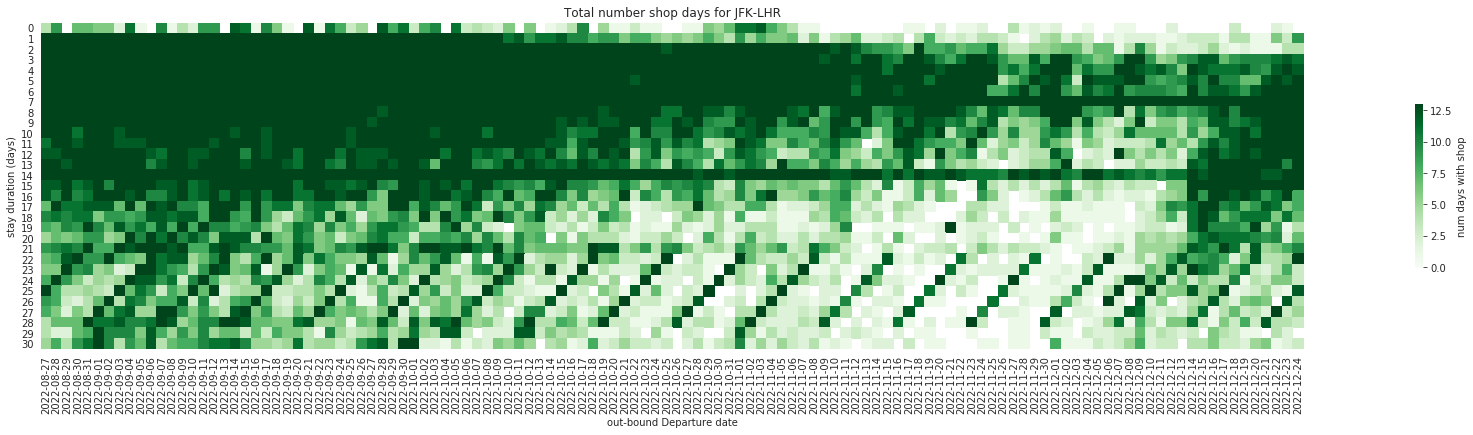

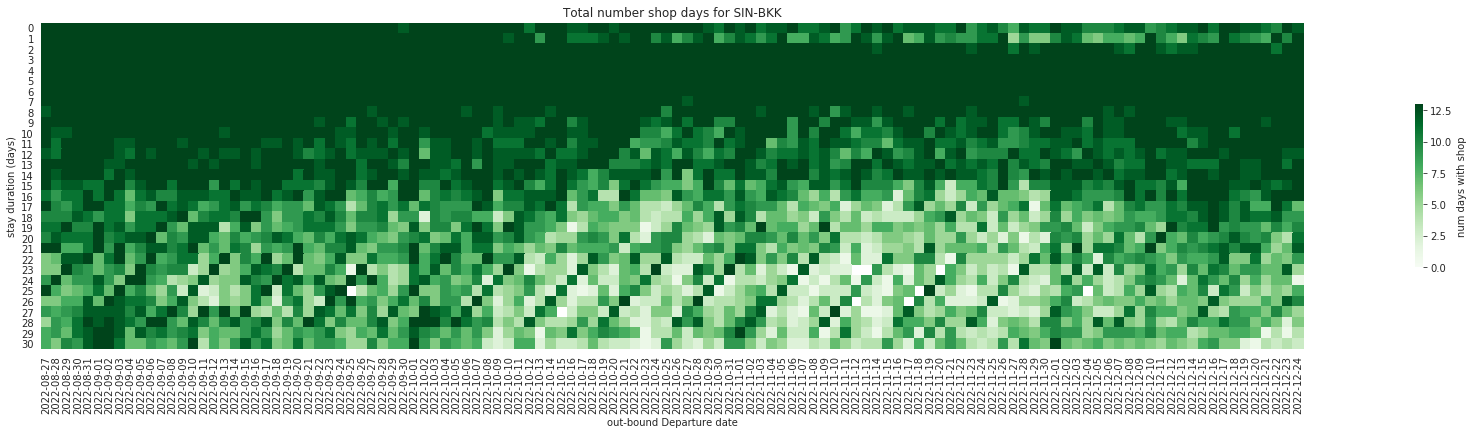

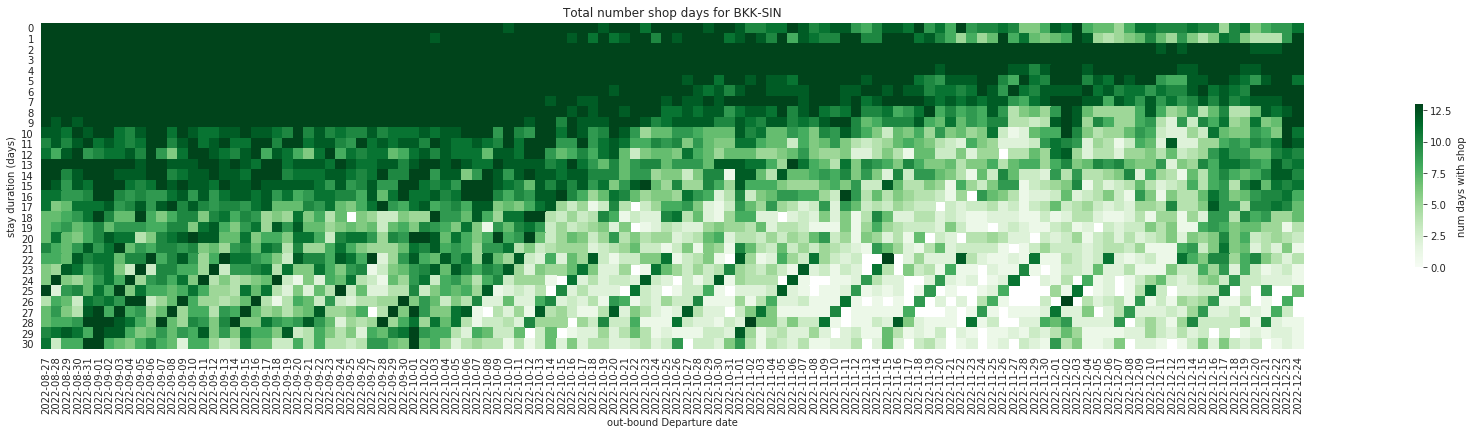

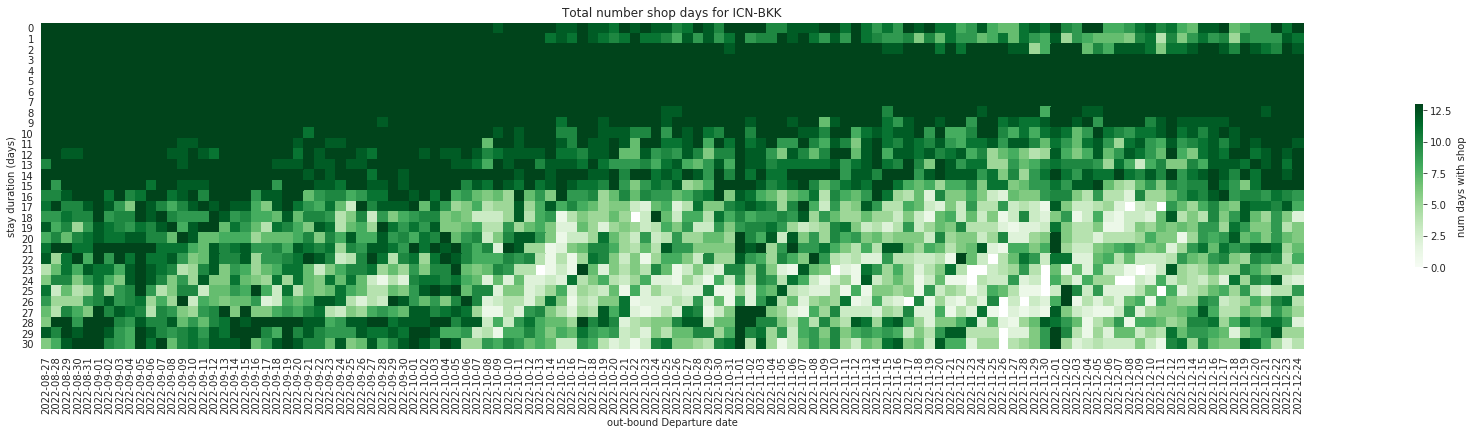

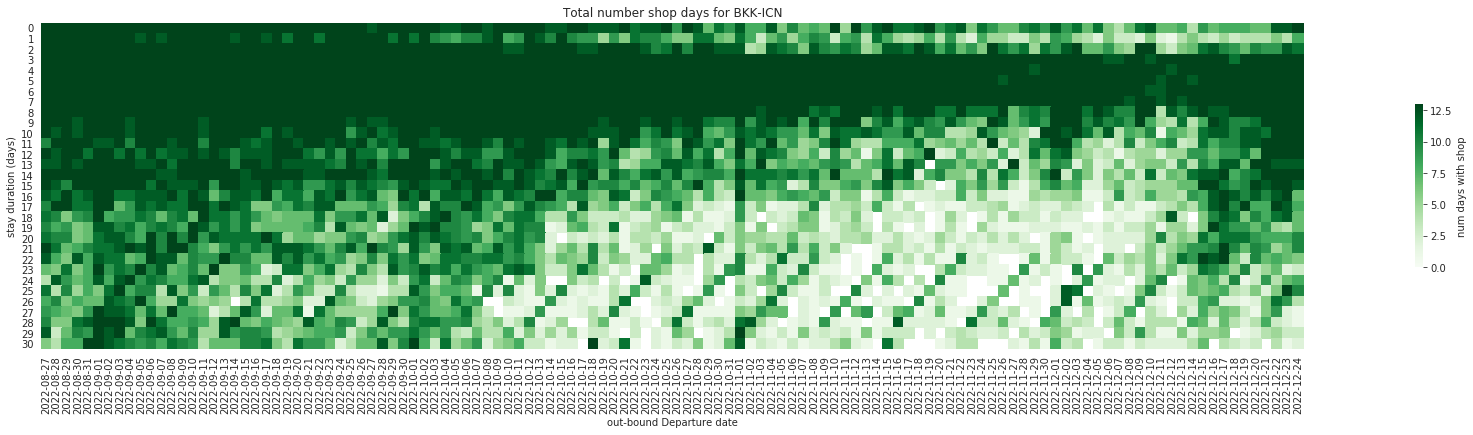

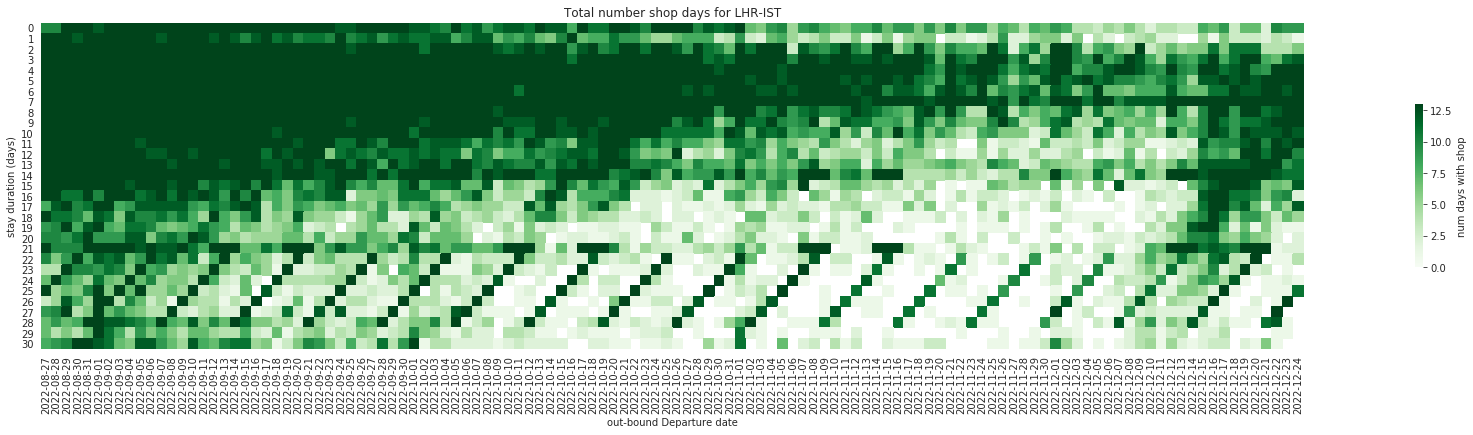

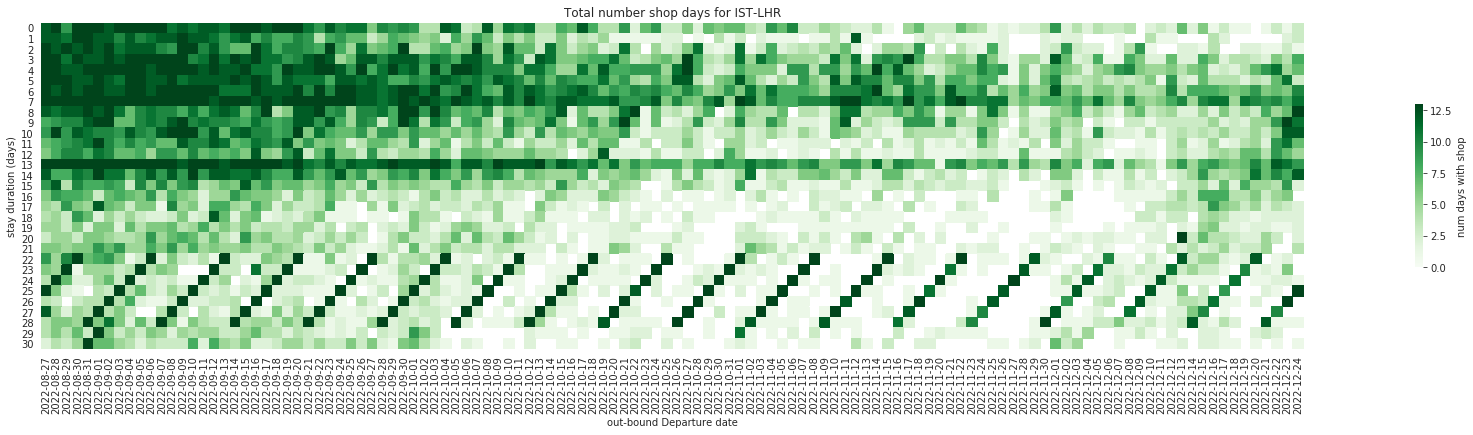

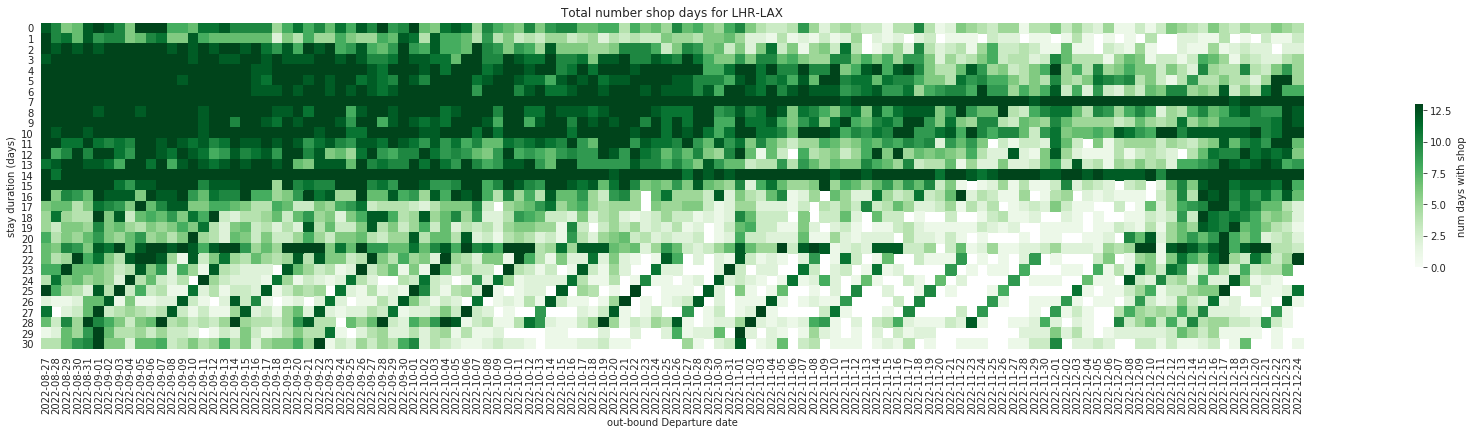

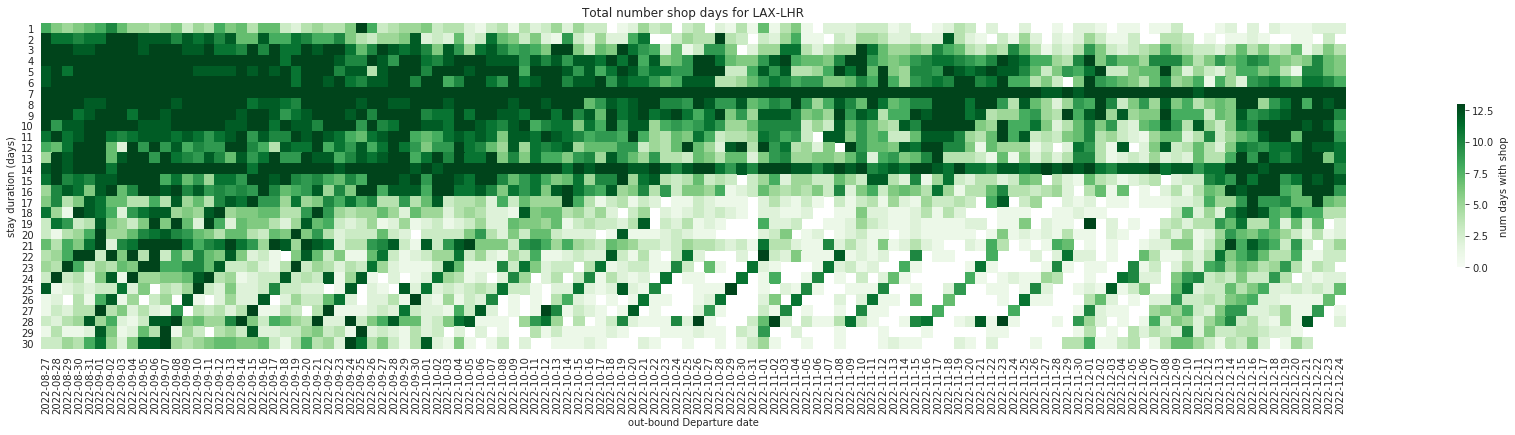

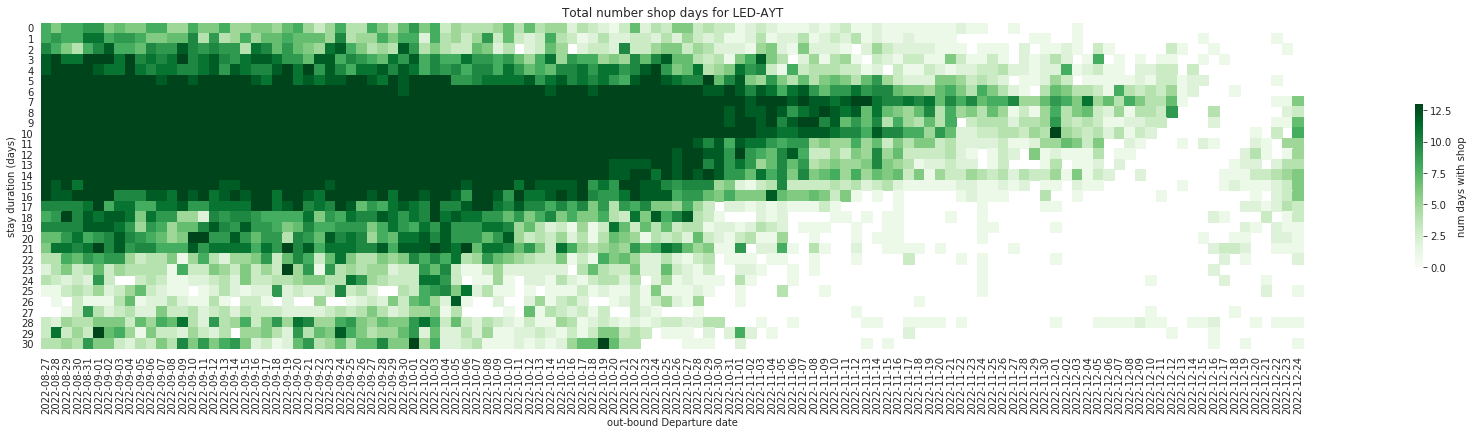

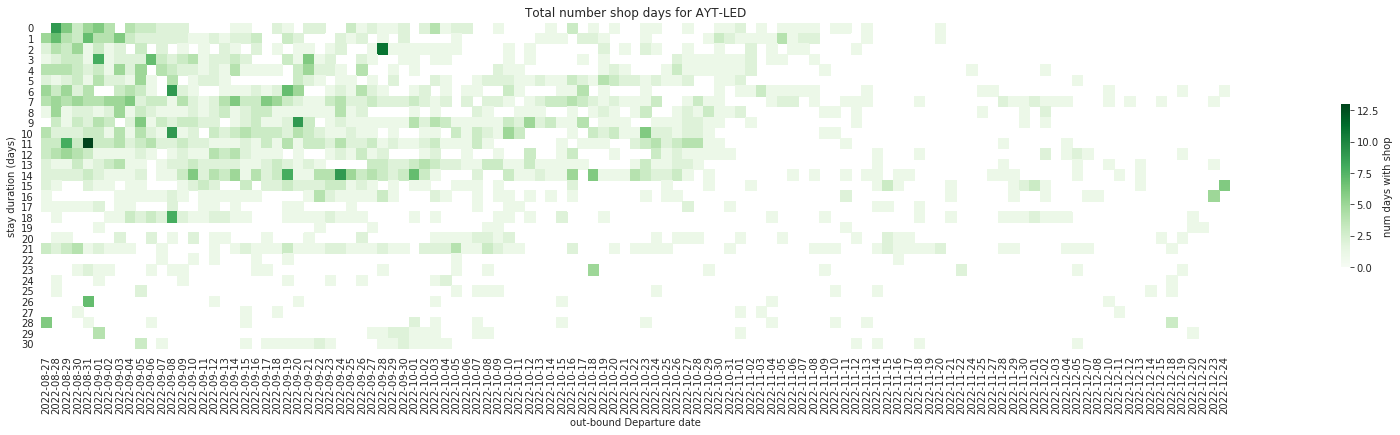

In [25]:
i = 0
for market in market_list[i*chunk: (i+1)*chunk]:
    pivot_plot_save(market, cnt_df, True)

Working on LED-AER
Working on MAN-ISB
Working on LHR-DXB
Working on DEL-GOI
Working on DEL-BOM
Working on SYD-MEL
Working on KWI-CAI
Working on AER-LED
Working on ISB-MAN
Working on DXB-LHR
Working on GOI-DEL
Working on BOM-DEL


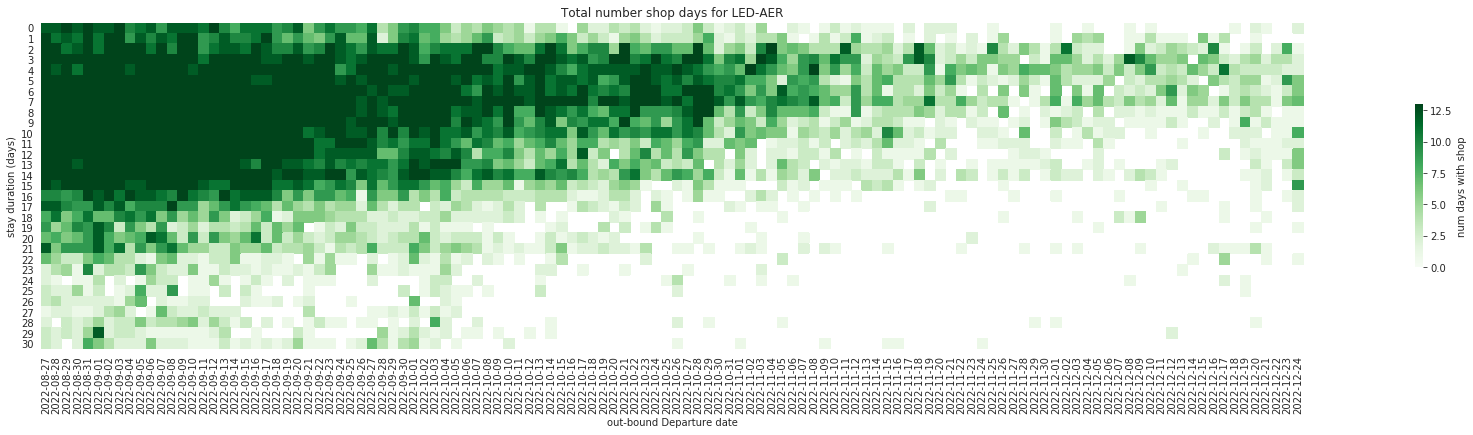

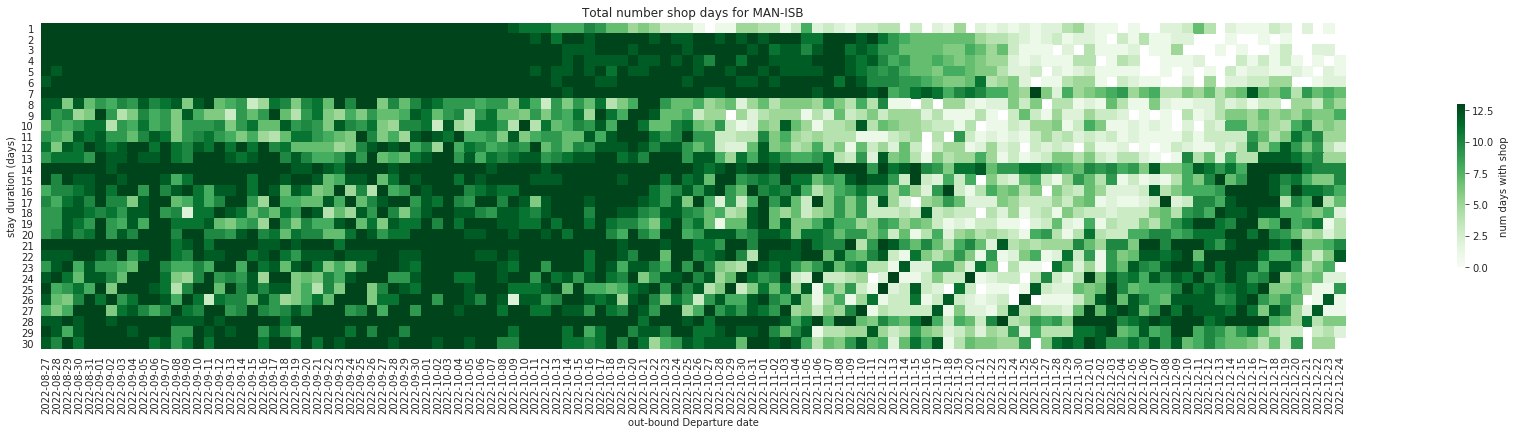

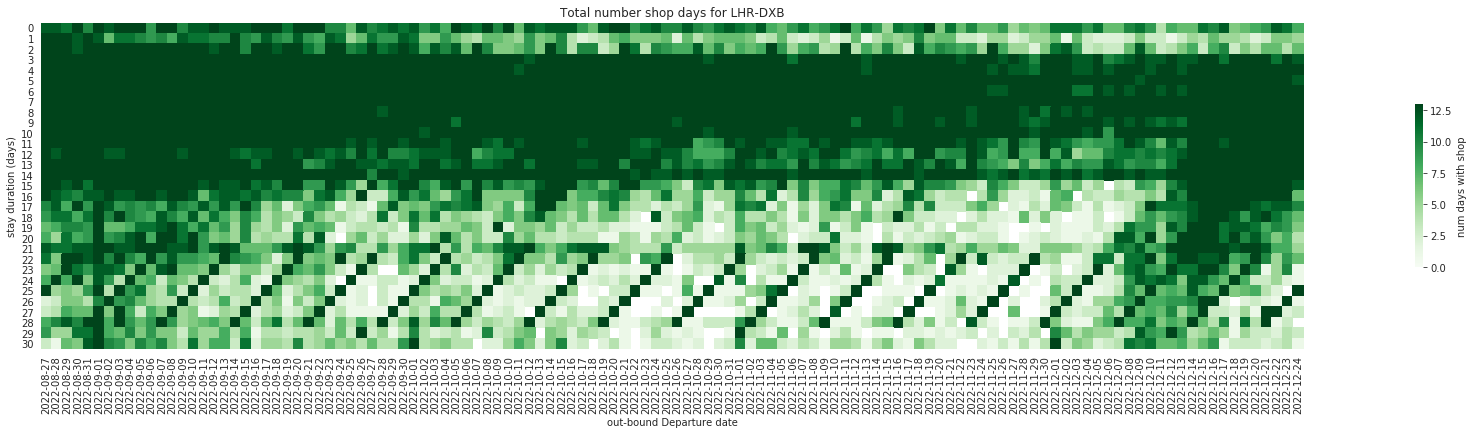

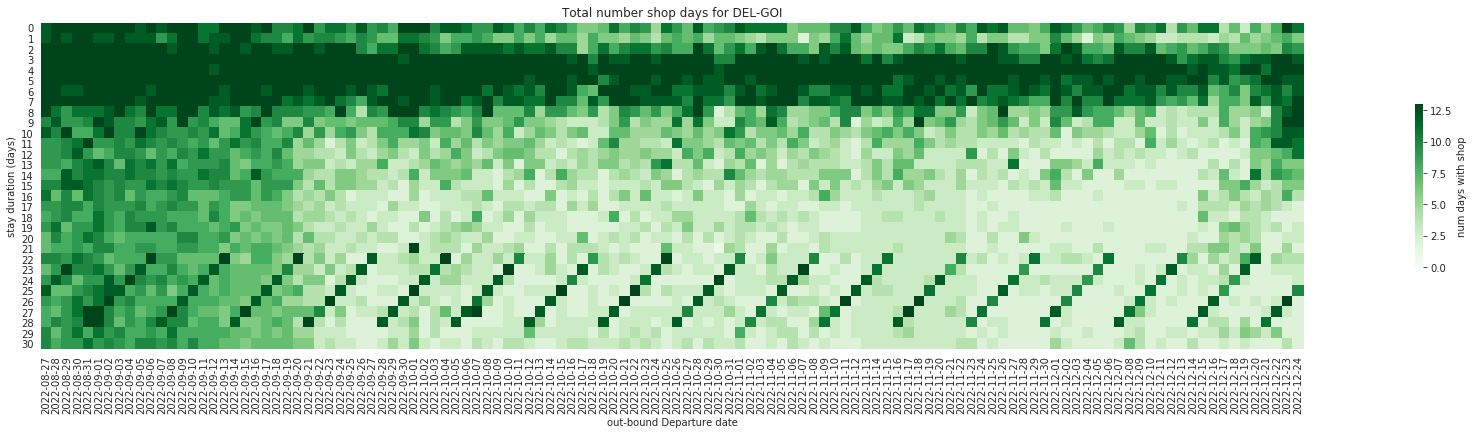

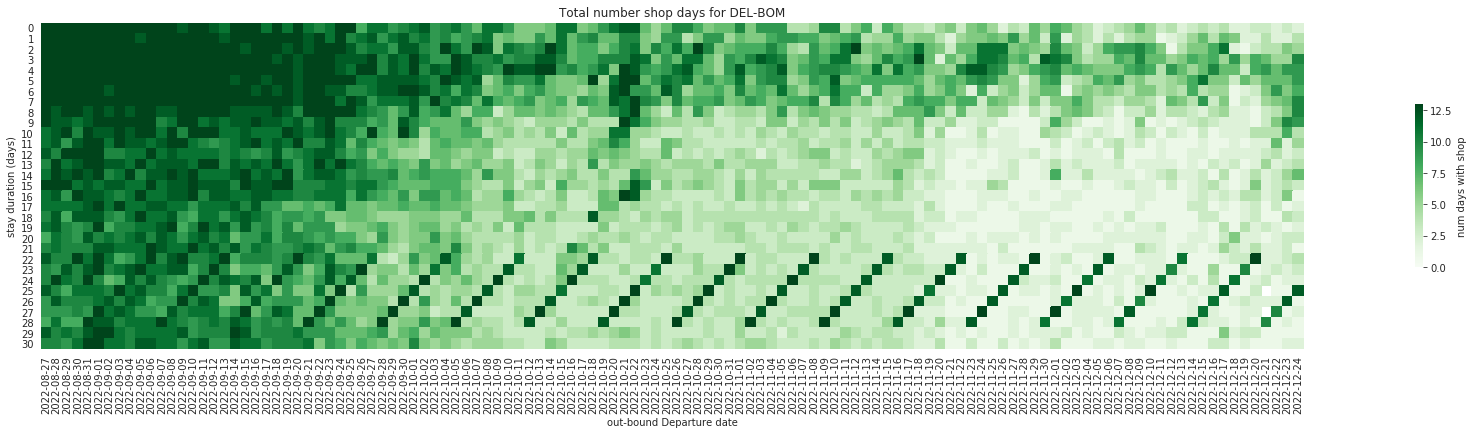

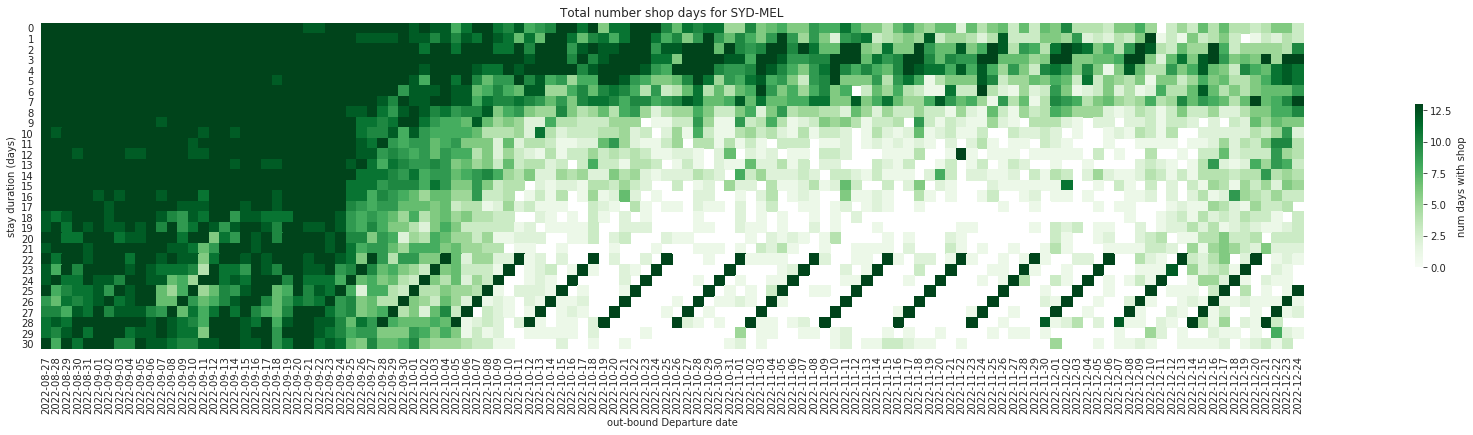

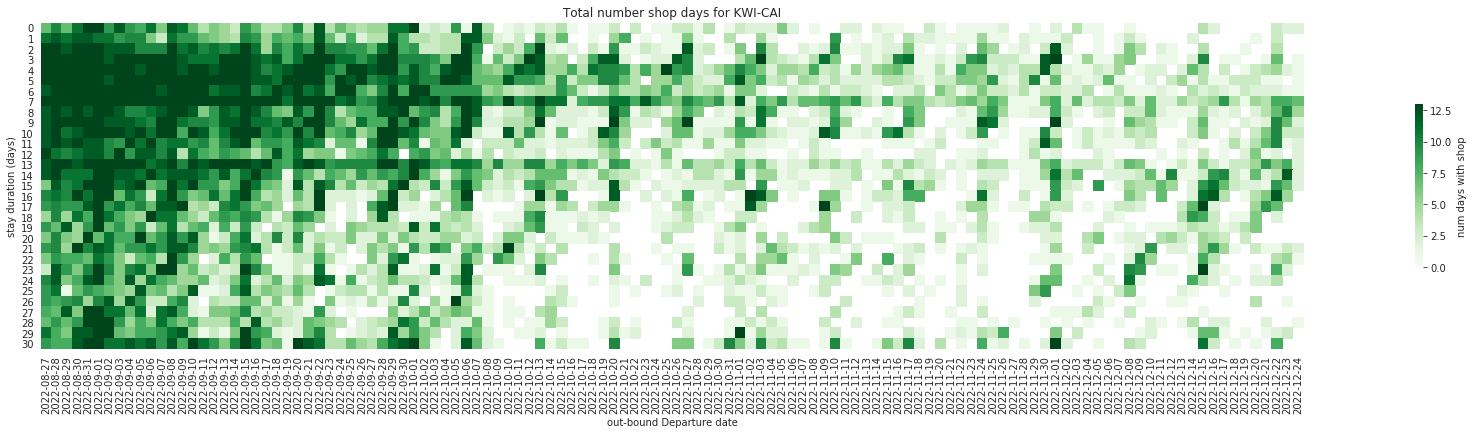

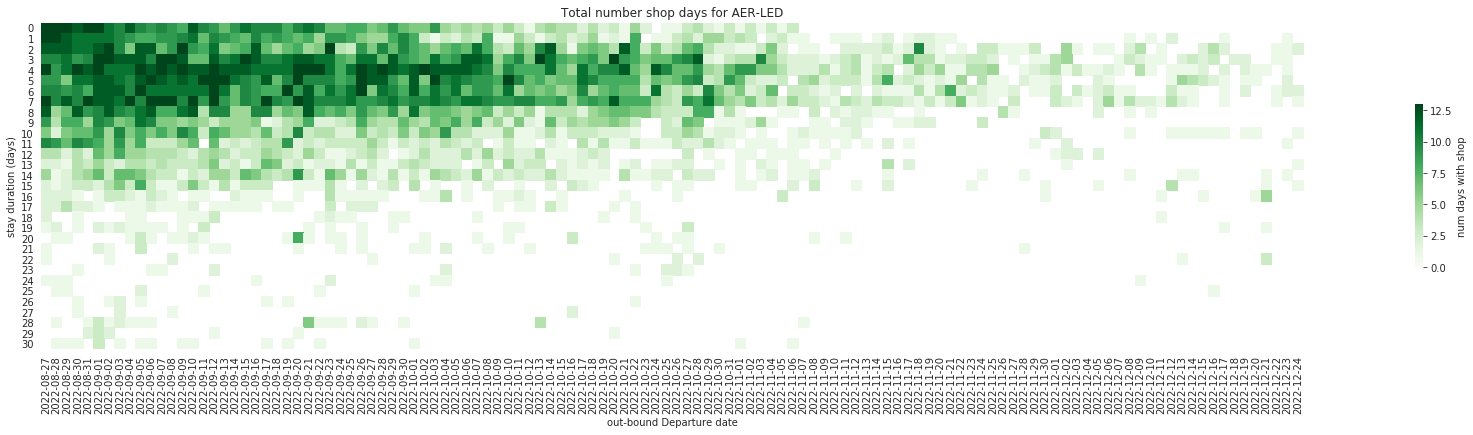

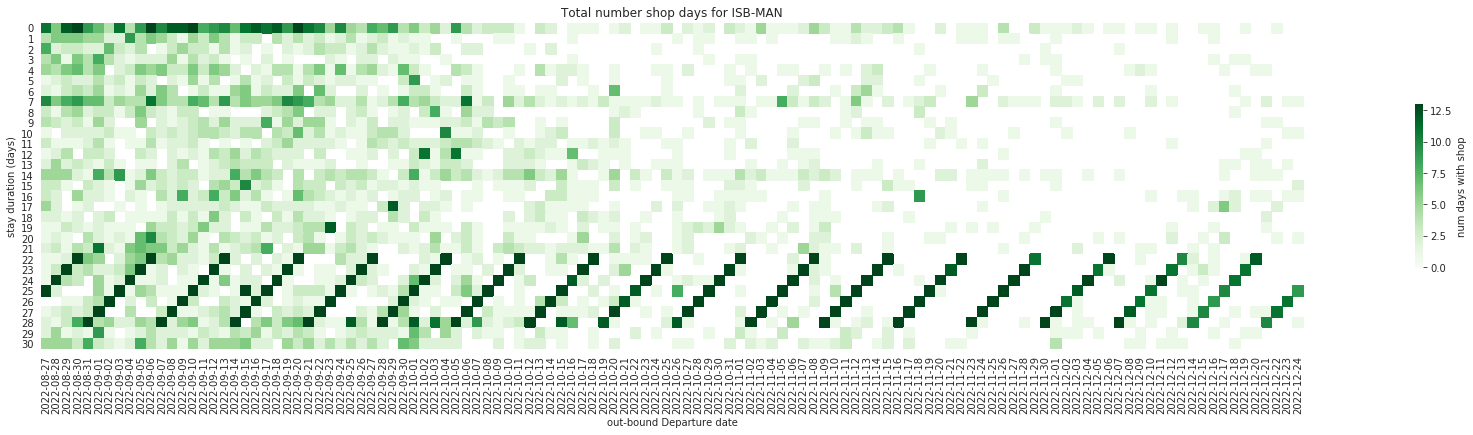

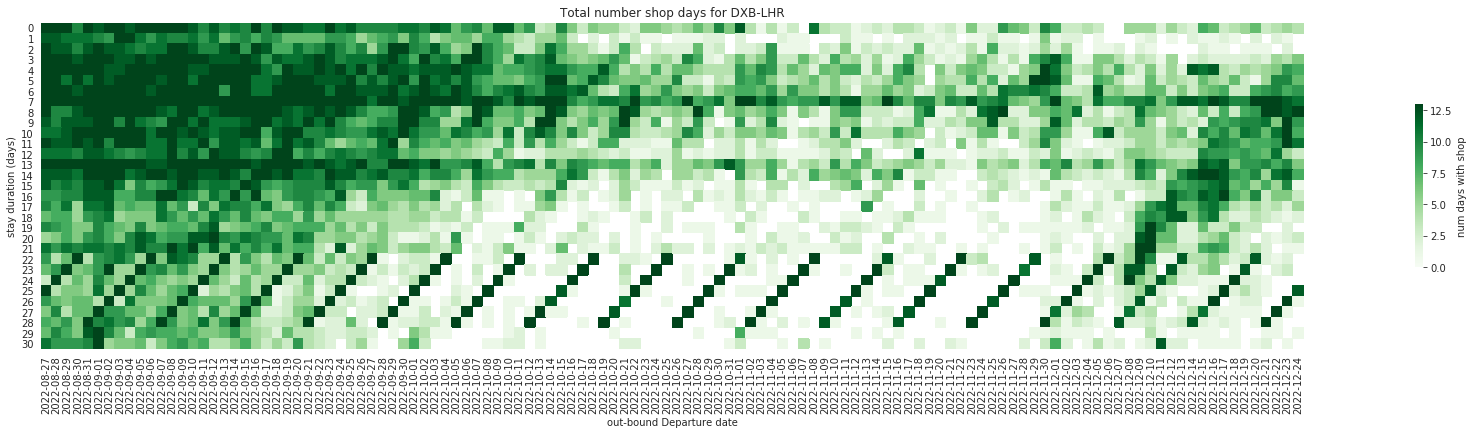

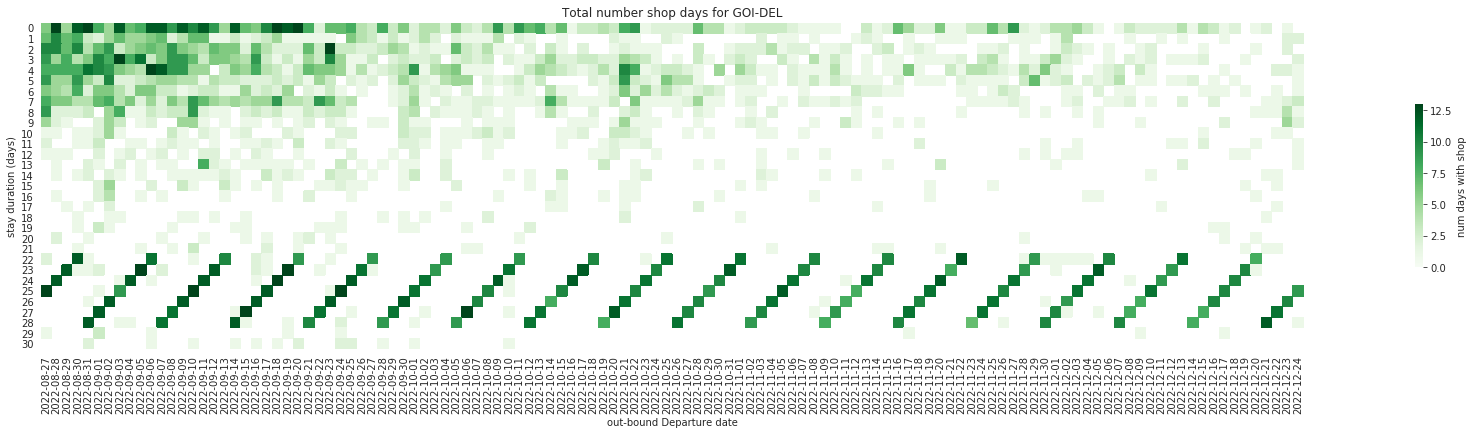

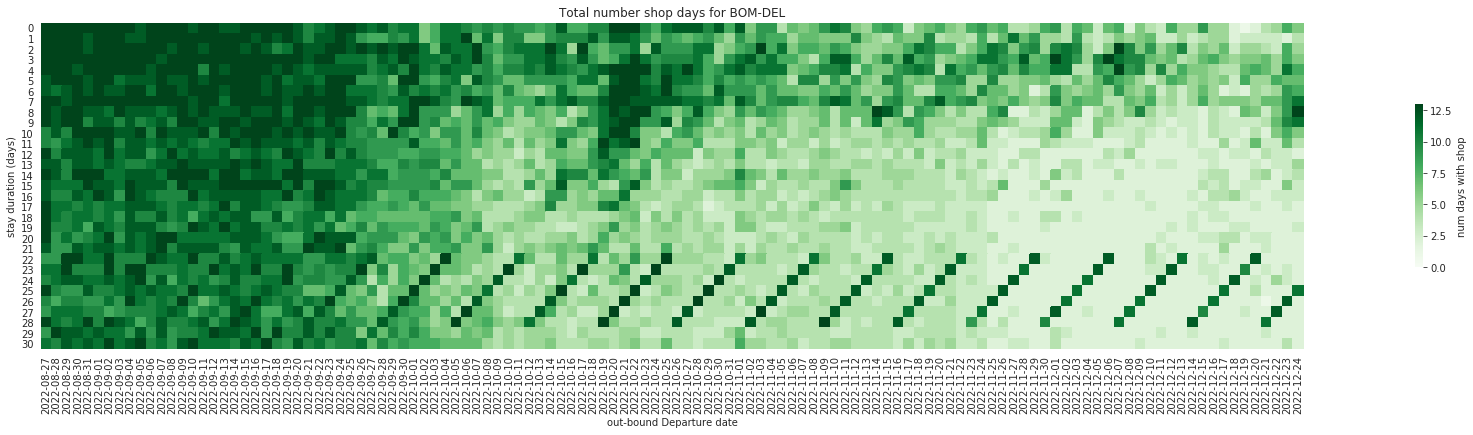

In [27]:
i = 1
for market in market_list[i*chunk: (i+1)*chunk]:
    pivot_plot_save(market, cnt_df, True)

Working on JFK-LAX
Working on LAX-JFK
Working on DFW-ORD
Working on ORD-DFW
Working on ATL-LAS
Working on LAS-ATL
Working on SFO-HNL
Working on HNL-SFO
Working on SFO-LAX
Working on LAX-SFO


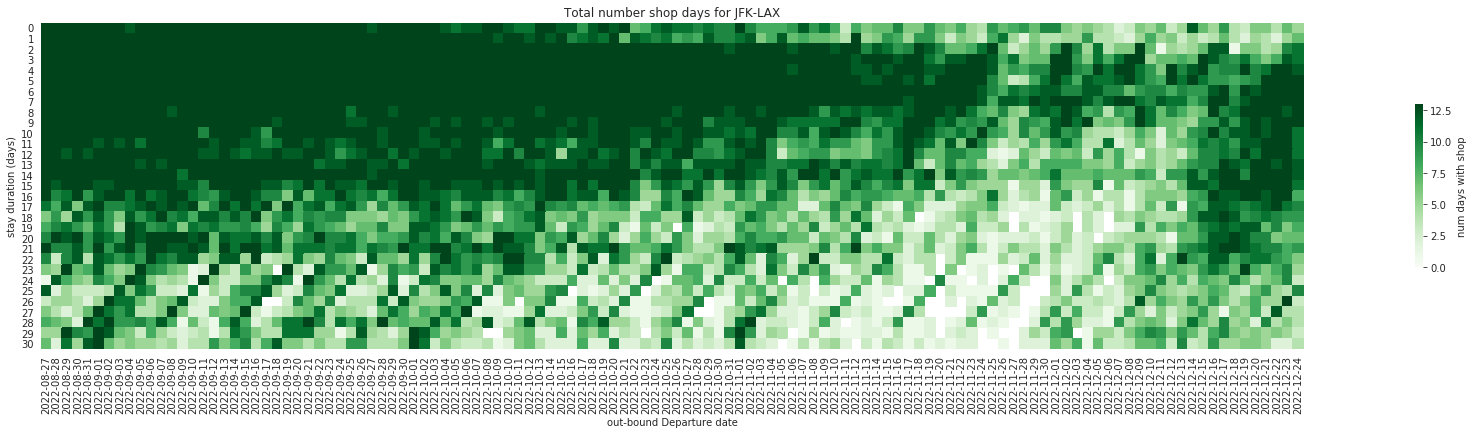

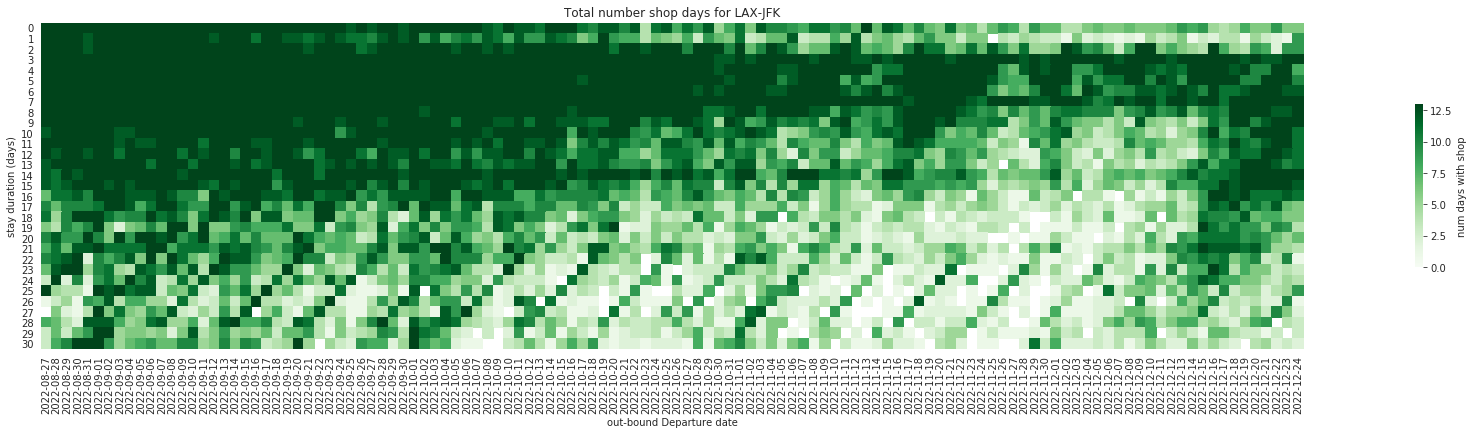

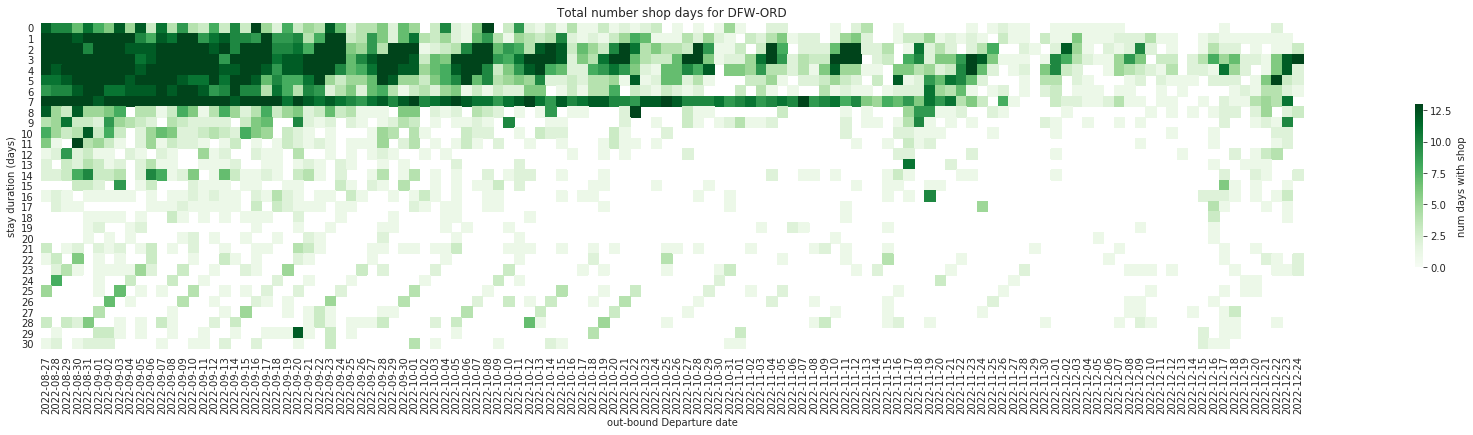

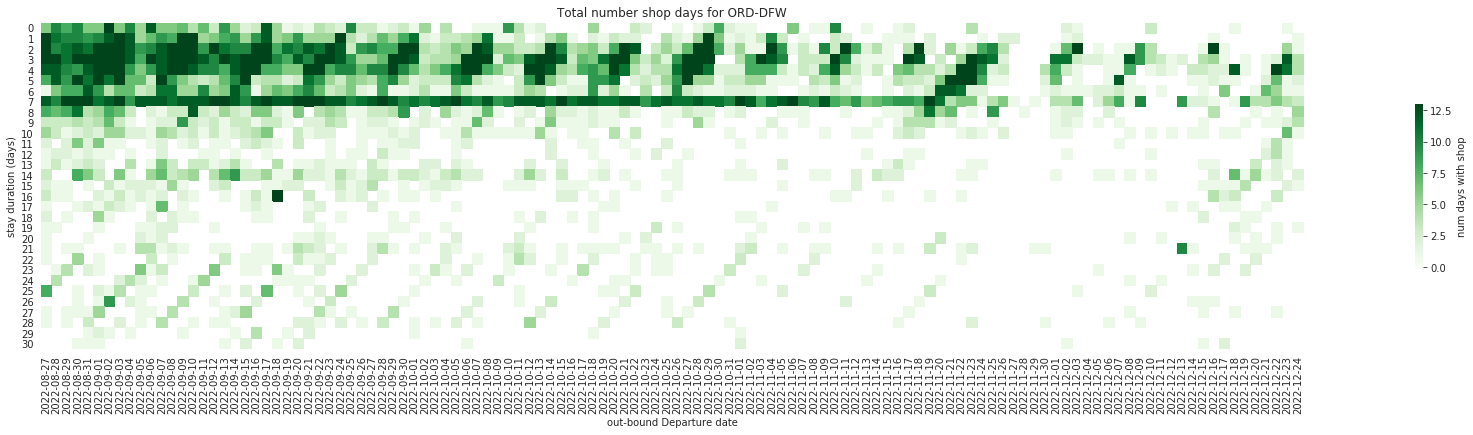

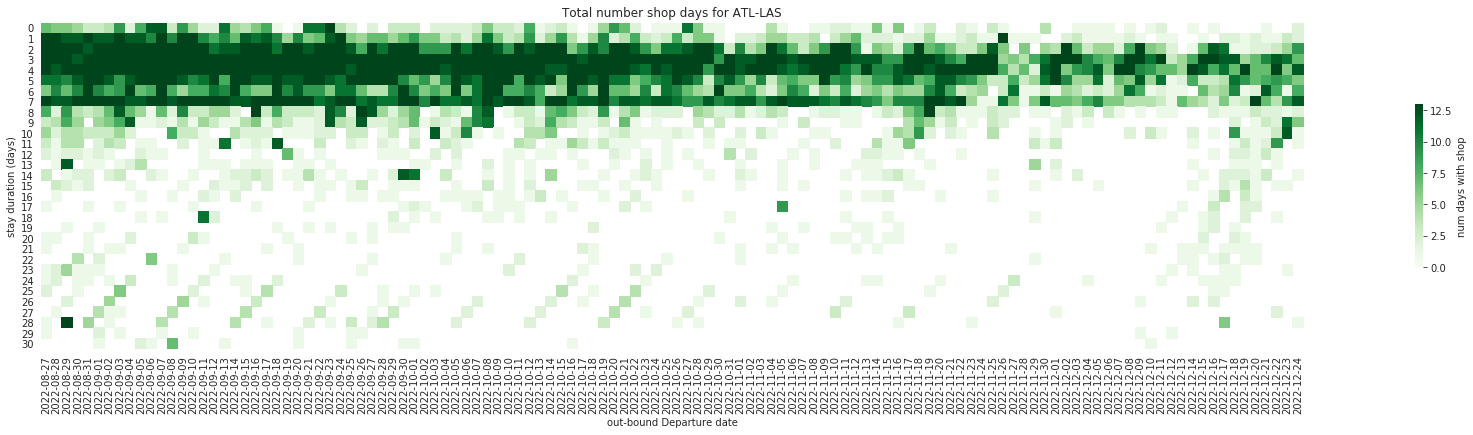

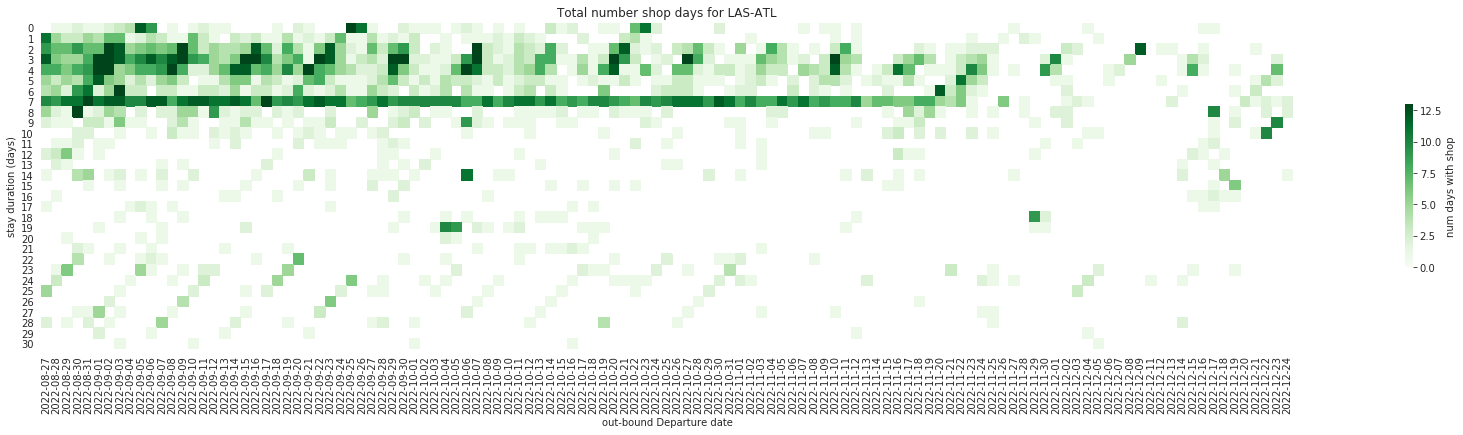

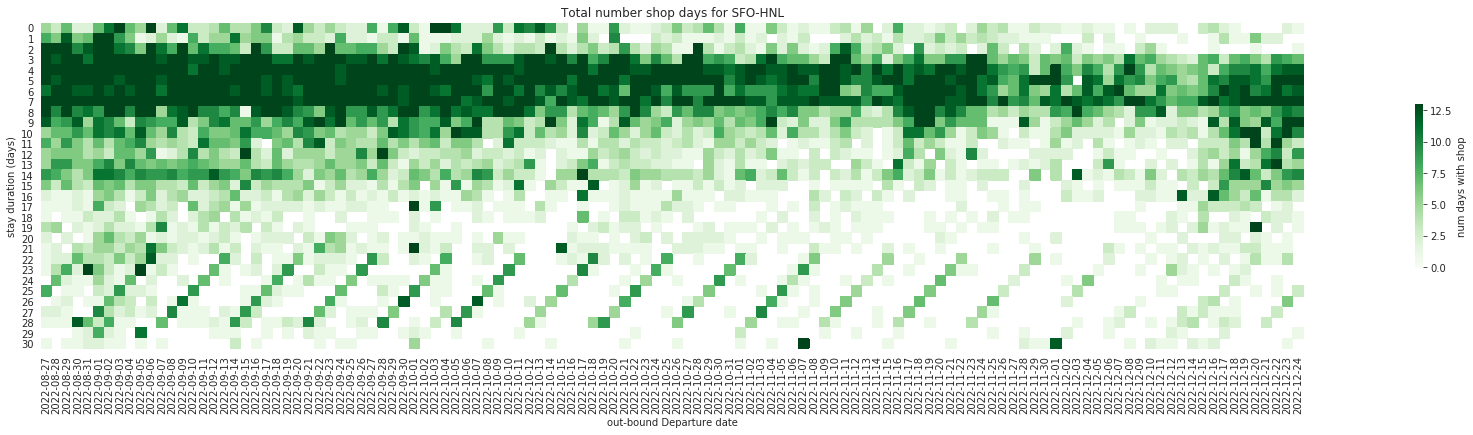

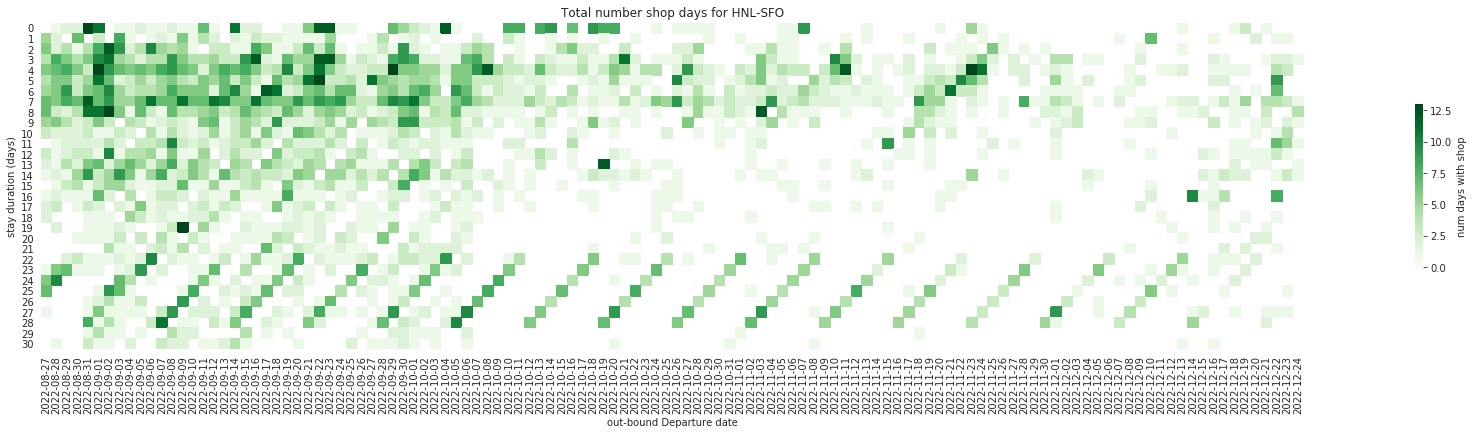

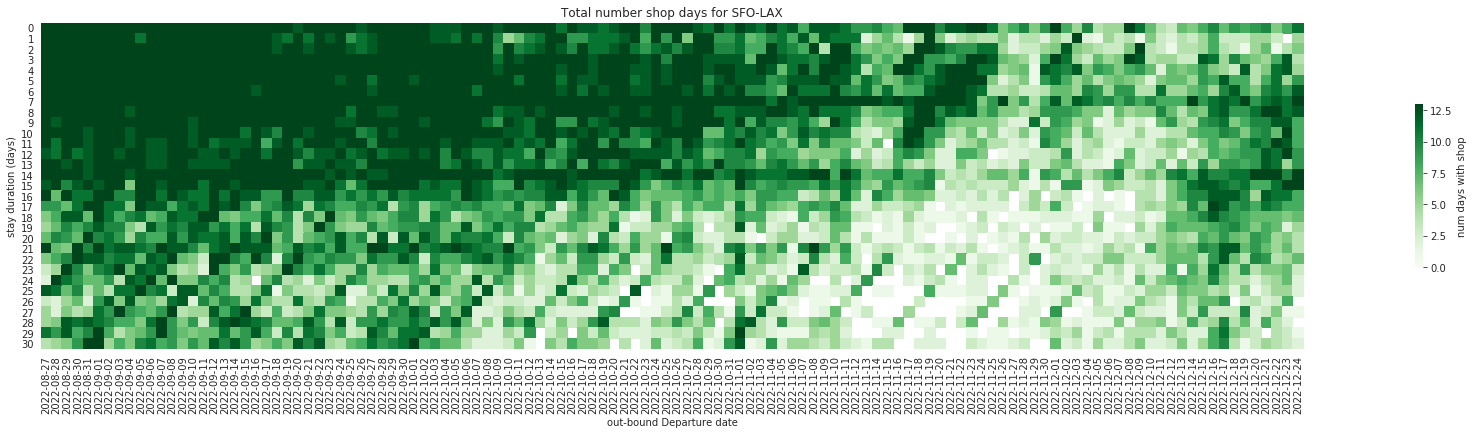

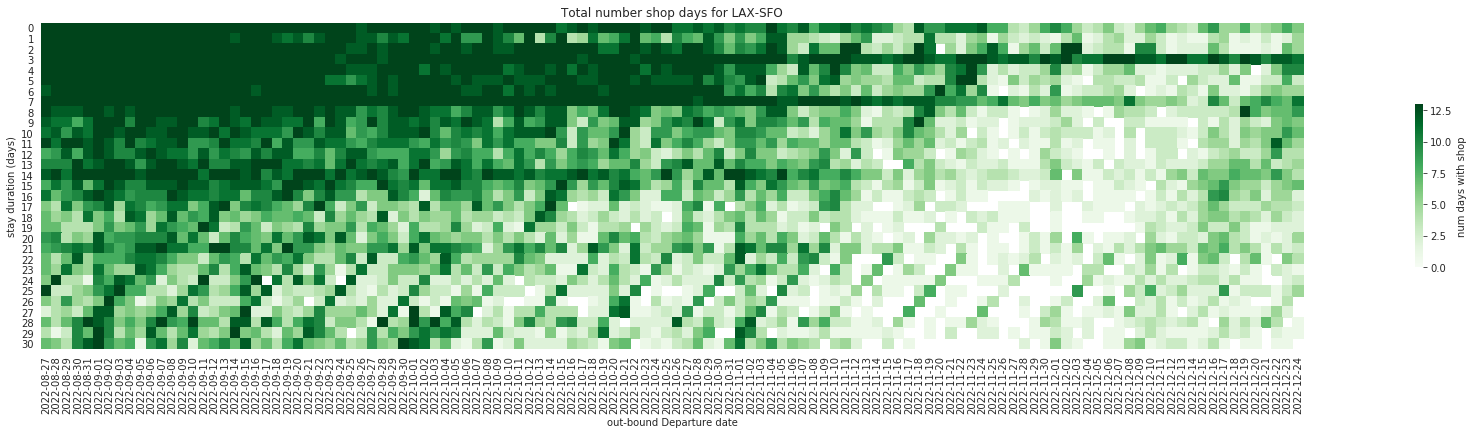

In [28]:
us_domestic_markets = ["JFK-LAX",
"LAX-JFK",
"DFW-ORD",
"ORD-DFW",
"ATL-LAS",
"LAS-ATL",
"SFO-HNL",
"HNL-SFO",
"SFO-LAX",
"LAX-SFO",]

for market in us_domestic_markets:
    pivot_plot_save(market, cnt_df, True)

Working on LHR-BKK
Working on MIA-CUN
Working on ATL-CUN


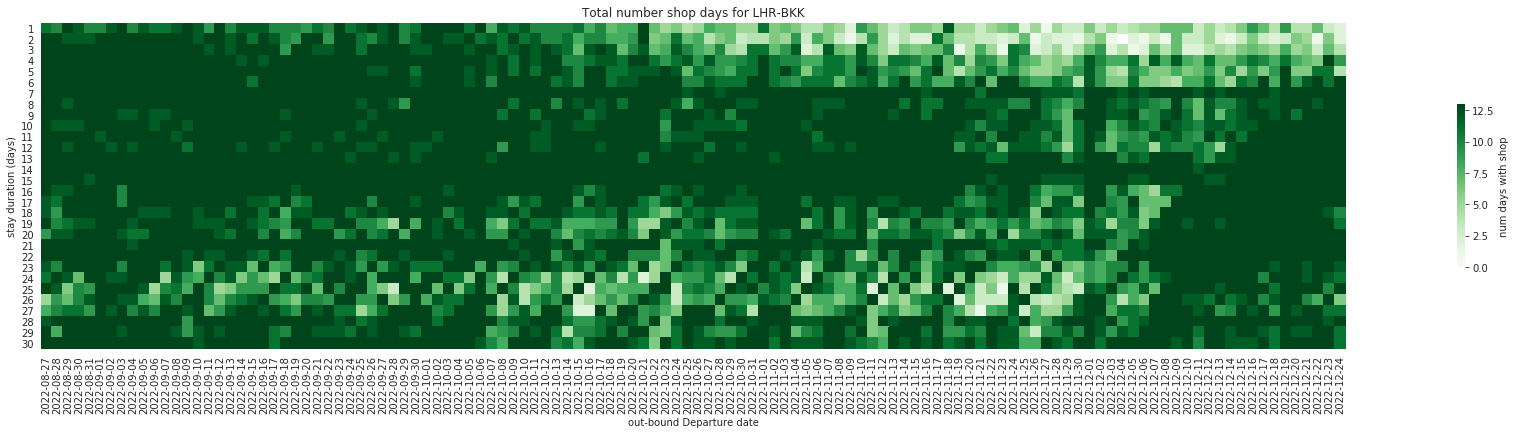

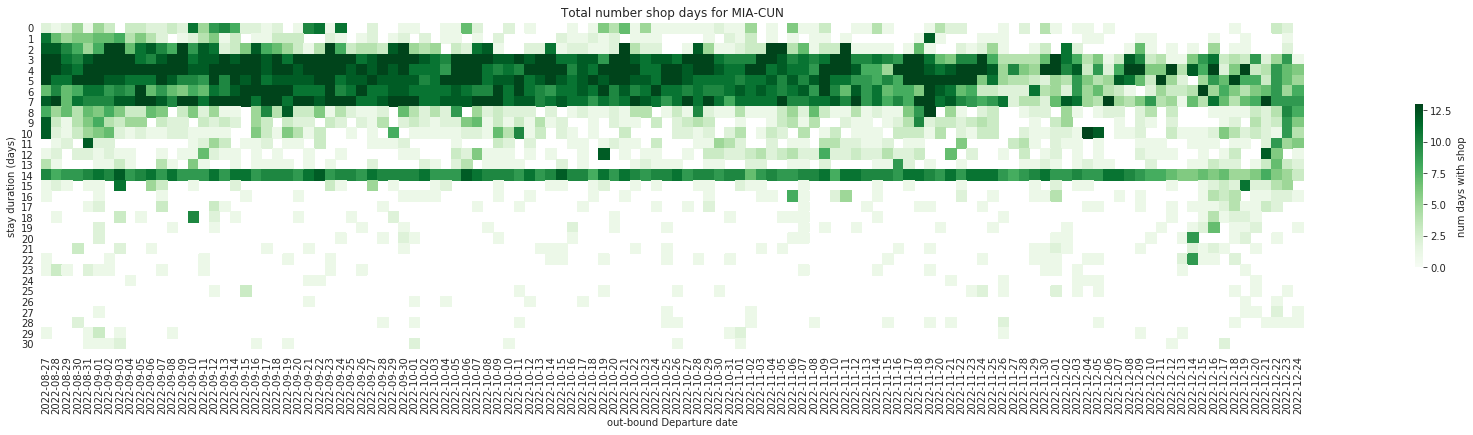

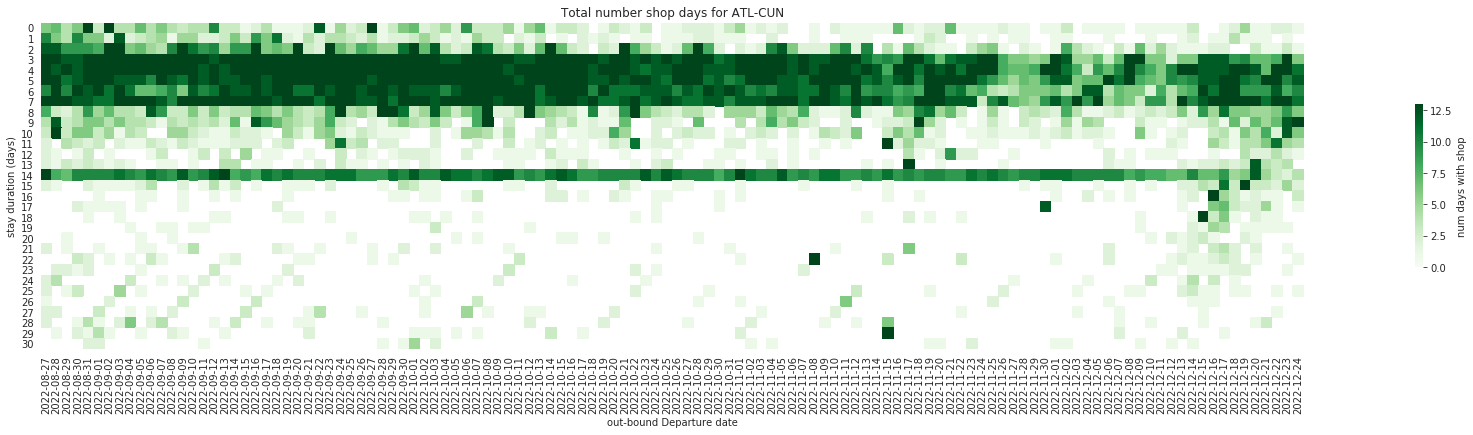

In [29]:
destination_markets = [# destination
"LHR-BKK",
# "BKK-LHR",
# "LHR-DIA",
# "CDG-DIA",
# "GIG-DIA",
# "GRU-DIA",
# "FRA-DIA",
# "MEX-DIA",
# "JFK-DIA",
# "LAX-DIA",
"MIA-CUN",
"ATL-CUN",
]
for market in destination_markets:
    pivot_plot_save(market, cnt_df, True)